In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

In [58]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

1. Data Preparation: Use PyTorch to load the CIFAR-10 dataset, perform a stratified random split in the ratio of 0.8:0.2 for the training and validation datasets. Here, the 15,000 images from the training dataset are split into train-val via 0.8:0.2
split, and 3,000 images (1,000 per class) are retained as the testing data from the original test dataset of CIFAR-10. Create a custom Dataset class for the data and create data loaders for all the dataset splits - train, val, and test.

In [59]:
# Load the dataset:
cifar10Train=datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
cifar10Test=datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

# Choose  classes:
selected_classes=['horse', 'ship', 'truck']
selected_indices=[]
for i in range(len(cifar10Train.classes)):
    if cifar10Train.classes[i] in selected_classes:
        selected_indices.append(i)
# print(selected_indices)

# Select class data:
trainData=[]
trainImages=[]
trainLabels=[]
for img, label in cifar10Train:
    if label in selected_indices:
        trainData.append((img,label))
        trainImages.append(img)
        trainLabels.append(label)

testData=[]
testImages=[]
testLabels=[]
for img, label in cifar10Test:
    if label in selected_indices:
        testData.append((img,label))
        testImages.append(img)
        testLabels.append(label)

trainLabels=np.array(trainLabels)
testLabels=np.array(testLabels)

# Stratified split
train_indices,val_indices=train_test_split(np.arange(len(trainLabels)),test_size=0.2,random_state=42,stratify=trainLabels)
train_split=Subset(trainData,train_indices)
val_split=Subset(trainData,val_indices)
train_loader=DataLoader(train_split,batch_size=64,shuffle=True)
val_loader=DataLoader(val_split,batch_size=64,shuffle=False)

#test set 
test_split_indices=[]
for i in selected_indices:
    indices=np.where(testLabels==i)[0]
    test_split_indices.extend(indices[:1000])
test_split=Subset(testData, test_split_indices)
test_loader=DataLoader(test_split,batch_size=64,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


2. Visualization: Load the dataset and visualize 5 images of each class from both the training and validation datasets.

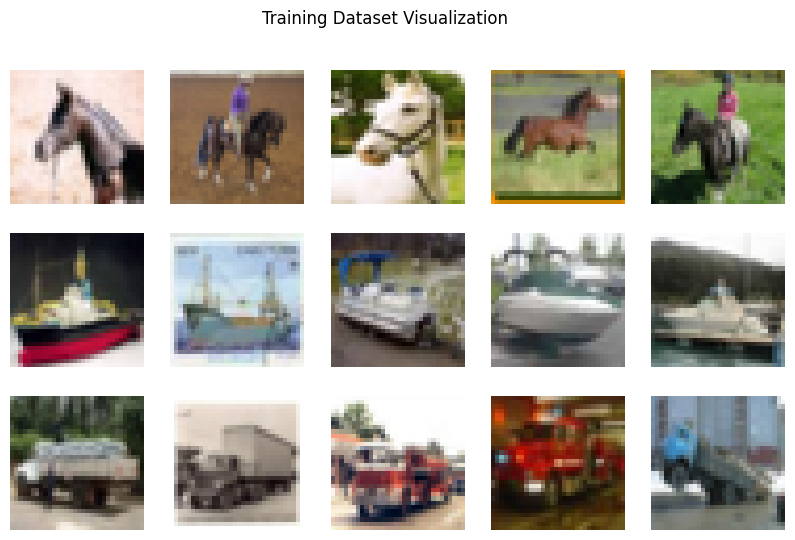

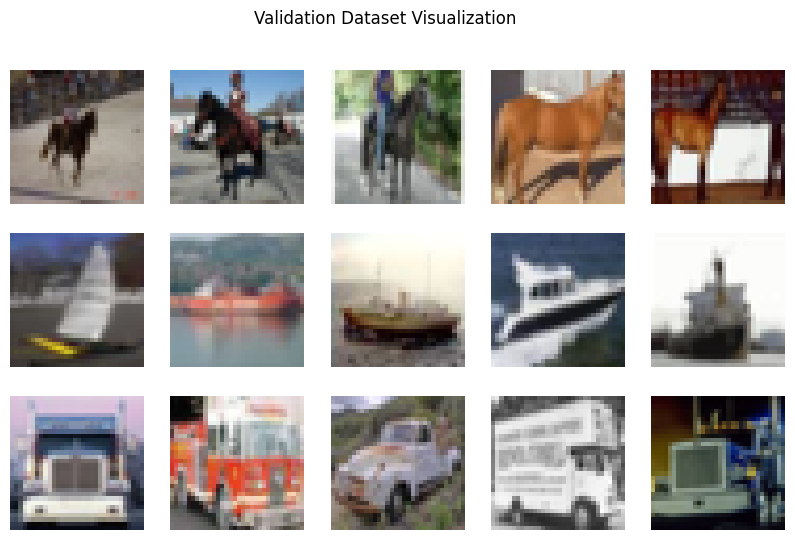

In [60]:
dataset=train_split
title="Training Dataset Visualization"
class_samples={}
for i in selected_indices:
    class_samples[i]=[]

count=0
for i in dataset:
    img=i[0]
    label=i[1]
    if len(class_samples[label])<5:
        class_samples[label].append(img)
        count+=1
    if count == 15:
        break

fig,axs=plt.subplots(len(selected_indices),5,figsize=(10, 6))
for i,cls in enumerate(selected_indices):
    for j in range(5):
        img=class_samples[cls][j].permute(1,2,0)*0.5+0.5
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
plt.suptitle(title)
plt.show()

dataset=val_split
title="Validation Dataset Visualization"
class_samples={}
for i in selected_indices:
    class_samples[i]=[]

count=0
for i in dataset:
    img=i[0]
    label=i[1]
    if len(class_samples[label])<5:
        class_samples[label].append(img)
        count+=1
    if count==15:
        break

fig,axs = plt.subplots(len(selected_indices),5,figsize=(10,6))
for i,cls in enumerate(selected_indices):
    for j in range(5):
        img=class_samples[cls][j].permute(1,2,0)*0.5+0.5
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
plt.suptitle(title)
plt.show()

3. CNN Implementation: Create a CNN architecture with 2 convolutional
layers (using in-built PyTorch implementations) having a kernel size of 5 x 5, 16
channels, padding and stride of 1 for the first layer, and kernel size of 3 x 3, 32
channels, stride of 1, and padding of 0 for the second layer. Use max-pooling layers
with a kernel size of 3 x 3 with a stride of 2 after the first convolutional layer
and a kernel size of 3 x 3 with stride 3 after the second convolutional layer. After
the second max pooling layer, flatten out the output and add it to a multi-layer
perceptron, with 16 neurons in the first layer and the classification head as the
second layer. Use the ReLU activation function after each layer other than the last
layer (the classification head layer).

In [61]:
_1stConvo=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=1)
_1stpool=nn.MaxPool2d(kernel_size=3,stride=2)
_2ndConvo=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=0)
_2ndpool=nn.MaxPool2d(kernel_size=3,stride=3)

def cnn_forward(x):
    x = F.relu(_1stConvo(x))
    x = _1stpool(x)
    x = F.relu(_2ndConvo(x))
    x = _2ndpool(x)
    x = torch.flatten(x, 1)
    x = F.relu(nn.Linear(32*4*4,16))
    x = nn.Linear(16,3)
    return x